<a href="https://colab.research.google.com/github/mohamedahshaan/MachineLearning_CW/blob/main/CM2604_ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM2604 – Machine Learning Coursework
## Telco Customer Churn Prediction
### By: Mohamed Ahshaan

This Notebook Includes:
- Task 1: Exploratory Data Analysis (EDA)
- Task 2: Decision Tree & Neural Network Models
- Task 3: AI Ethics


# Import Libraries

In [16]:
# ============================================
# Import Libraries
# ============================================

# Core data handling
import pandas as pd
import numpy as np

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline + Model Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Utility for displaying tables in Jupyter
from IPython.display import display

# Saving trained models
import joblib

# Set visual style for plots
sns.set(style="whitegrid")


# TASK - 01 | Exploratory Data Analysis

In [17]:
# ============================================
# Load Dataset
# ============================================

try:
    df = pd.read_csv("Telco_Customer_Churn.csv")
    print("--> Dataset loaded successfully.")
    print("Shape:", df.shape)

    # Show the first few rows (for validation)
    print("\n--> Displaying first 5 rows:")
    display(df.head())

except FileNotFoundError:
    print("--> Dataset not found. Please upload Telco_Customer_Churn.csv")


--> Dataset loaded successfully.
Shape: (7043, 21)

--> Displaying first 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
# ============================================
# Basic Cleaning + Dataset Information
# ============================================

# Convert TotalCharges to numeric (Some values contain spaces → NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing TotalCharges with median (prevents bias from extreme values)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Convert Churn to numerical (Yes - 1, No - 0) for modelling
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

# Display dataset structure
print("=== Dataset Info ===")
df.info()

# Check for missing values in all columns
print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704


Churn counts: {0: 5174, 1: 1869}
Churn %: {0: 73.46, 1: 26.54}


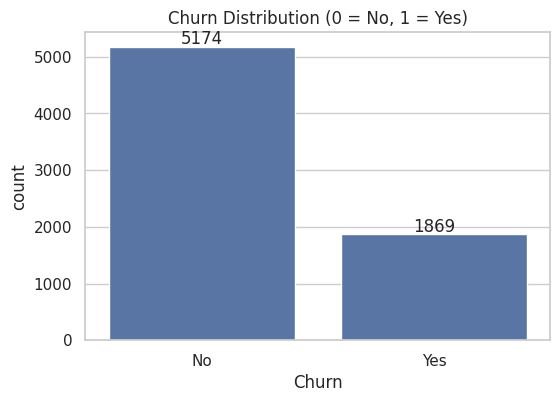

In [19]:
# ============================================
# Churn Count and Percentage with Bar Chart
# ============================================

# Count churners and non-churners
churn_counts = df["Churn"].value_counts()
churn_percent = (churn_counts / len(df) * 100).round(2)

print("\nChurn counts:", churn_counts.to_dict())
print("Churn %:", churn_percent.to_dict())

# Plot churn distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Churn", data=df)
ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Churn Distribution (0 = No, 1 = Yes)")

# Add numeric labels on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x()+p.get_width()/2, height + 50, height, ha="center")

plt.show()



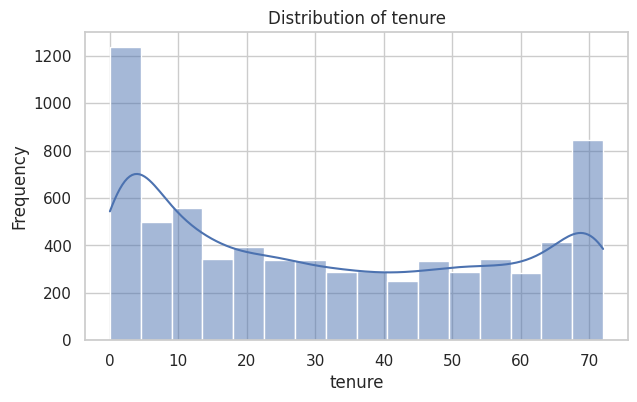

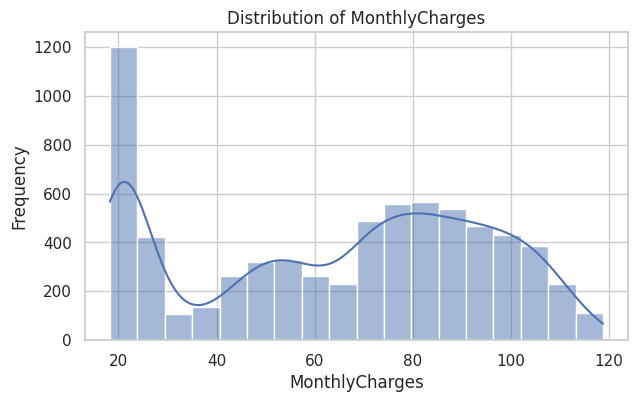

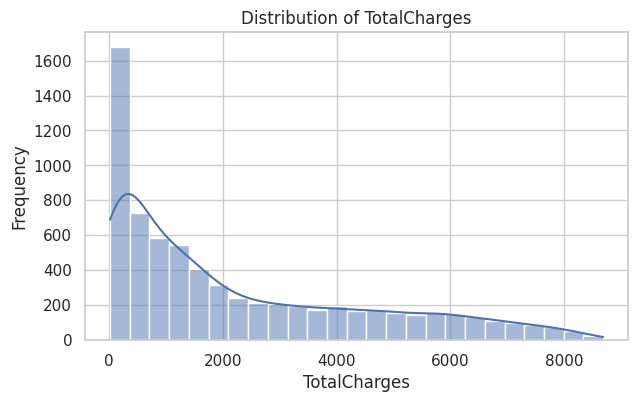

In [20]:
# ============================================
# Numeric Feature Distributions
# ============================================

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Plot histogram + KDE for each numeric column
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


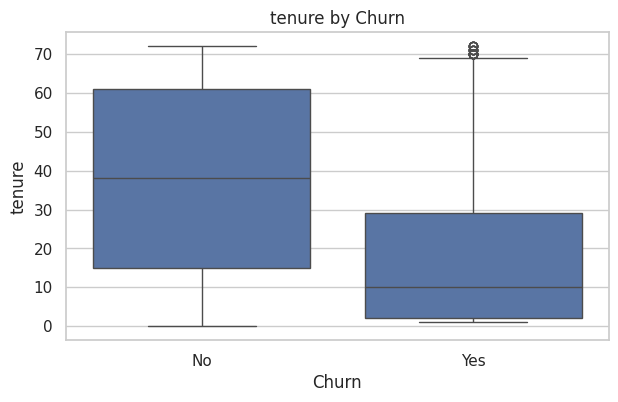

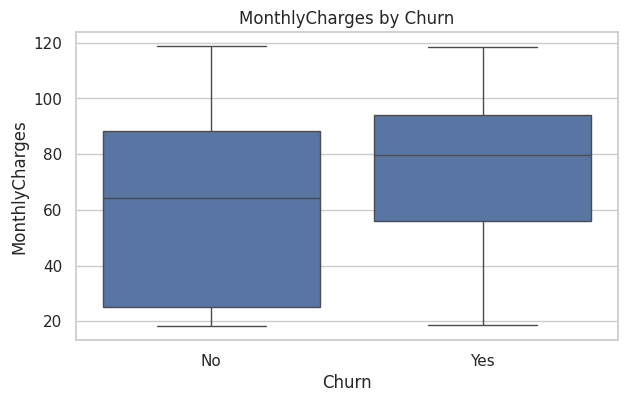

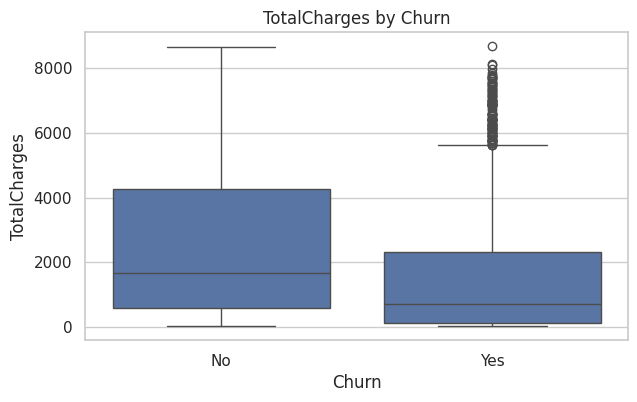

In [21]:
# ============================================
# Boxplots: Churn vs Numerical Features
# ============================================

for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} by Churn")
    plt.xticks([0,1], ["No","Yes"])
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.show()


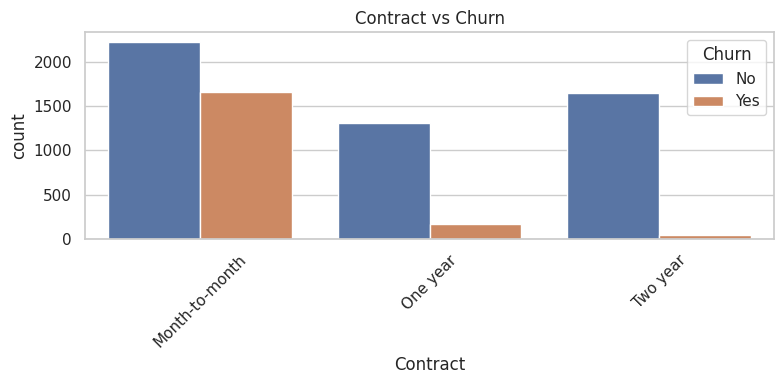

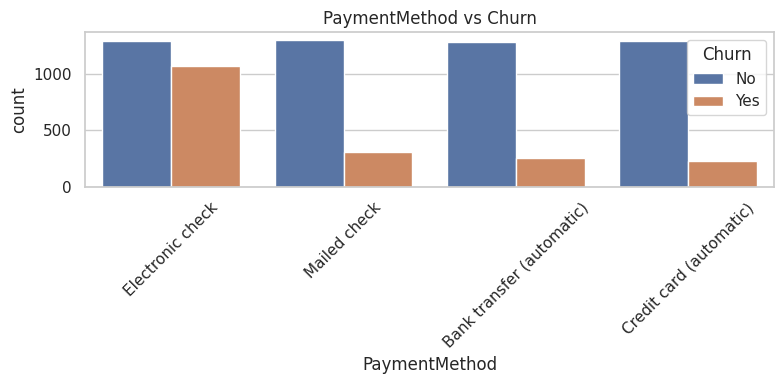

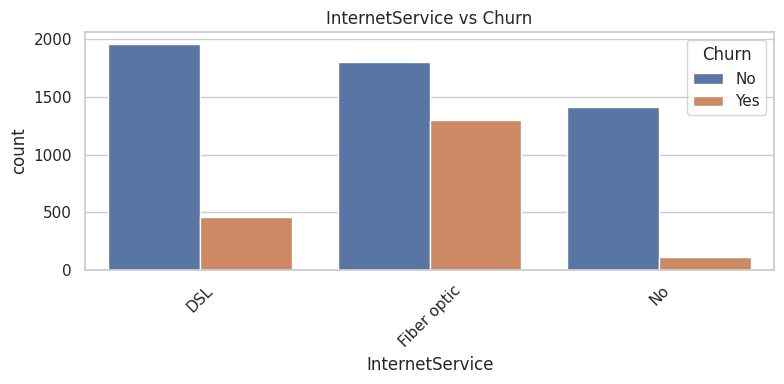

In [22]:
# ============================================
# Important Categorical Features vs Churn
# ============================================

cat_cols = ["Contract", "PaymentMethod", "InternetService"]

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue="Churn", data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.legend(title="Churn", labels=["No","Yes"])
    plt.tight_layout()
    plt.show()


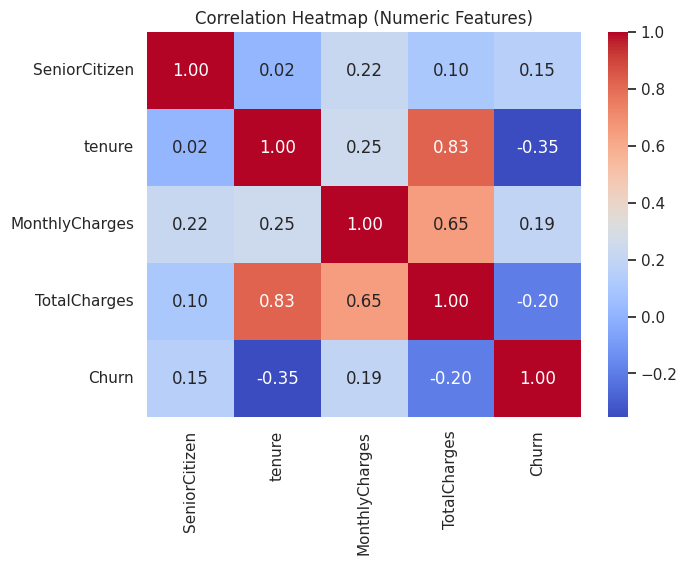

In [23]:
# ============================================
# Correlation Heatmap for Numeric Features
# ============================================

plt.figure(figsize=(7,5))
numeric_corr = df.select_dtypes(include=["int64","float64"]).corr()

sns.heatmap(numeric_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


# TASK - 02 | PREPROCESSING + MODELS + TUNING

In [24]:
# ============================================
# Prepare Data for Modelling
# ============================================

# Remove customerID (not useful for modelling)
df_model = df.drop(columns=["customerID"], errors="ignore")

# Split into features (X) and target (y)
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

# Identify numeric and categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Print Lists
print("=== Numeric Features ===")
for col in num_features:
    print(" -", col)

print("\n=== Categorical Features ===")
for col in cat_features:
    print(" -", col)



=== Numeric Features ===
 - SeniorCitizen
 - tenure
 - MonthlyCharges
 - TotalCharges

=== Categorical Features ===
 - gender
 - Partner
 - Dependents
 - PhoneService
 - MultipleLines
 - InternetService
 - OnlineSecurity
 - OnlineBackup
 - DeviceProtection
 - TechSupport
 - StreamingTV
 - StreamingMovies
 - Contract
 - PaperlessBilling
 - PaymentMethod


In [25]:
# ============================================
# PREPROCESSING PIPELINES
# ============================================

# Numeric pipeline
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine both
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])


In [26]:
# ============================================
# Train &Test Data Split
# ============================================

from sklearn.model_selection import train_test_split

# 80% training and 20% testing (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size :", X_test.shape)
print("Training positive (churn=1):", sum(y_train))
print("Testing positive (churn=1):", sum(y_test))



Training set size: (5634, 19)
Testing set size : (1409, 19)
Training positive (churn=1): 1495
Testing positive (churn=1): 374


In [27]:
# ============================================
# Decision Tree with Hyperparameter Tuning
# ============================================


# Create a Decision Tree pipeline (preprocessing + model together)
dt_pipeline = Pipeline([
    ("preproc", preprocessor),  # numeric + categorical preprocessing
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Hyperparameter search space
dt_params = {
    "clf__max_depth": [3, 5, 7, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__class_weight": [None, "balanced"]
}

# Grid Search (5-fold cross-validation)
dt_cv = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_params,
    scoring="f1",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Train the tuned model
dt_cv.fit(X_train, y_train)

# Extract the best model
dt_best = dt_cv.best_estimator_

# Print best parameters in a clean format
print("\n--> Best Decision Tree Parameters Found")
for key, value in dt_cv.best_params_.items():
    print(f"   • {key}: {value}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

--> Best Decision Tree Parameters Found
   • clf__class_weight: balanced
   • clf__max_depth: 3
   • clf__min_samples_split: 2


In [28]:
# ============================================
# MLP Classifier with Hyperparameter Tuning
# ============================================

from sklearn.neural_network import MLPClassifier

# Pipeline with preprocessing + MLP model
mlp_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", MLPClassifier(max_iter=500, random_state=42))
])

# Hyperparameter search space
mlp_params = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "clf__alpha": [0.0001, 0.001],
    "clf__learning_rate_init": [0.001, 0.01]
}

# GridSearchCV for tuning
mlp_cv = GridSearchCV(
    mlp_pipeline,
    mlp_params,
    scoring="f1",                          # Good for imbalanced data
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Train the model
mlp_cv.fit(X_train, y_train)

# Best tuned model
mlp_best = mlp_cv.best_estimator_

# Print best hyperparameters (clean format)
print("\n--> Best MLP Hyperparameters Found")
for param, value in mlp_cv.best_params_.items():
    print(f"   • {param}: {value}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

--> Best MLP Hyperparameters Found
   • clf__alpha: 0.001
   • clf__hidden_layer_sizes: (50,)
   • clf__learning_rate_init: 0.001


In [29]:
# ============================================
# Save Trained Models (Decision Tree + MLP)
# ============================================

# Save the best Decision Tree model
joblib.dump(dt_best, "best_decision_tree_model.pkl")
print("--> Saved : best_decision_tree_model.pkl")

# Save the best MLP model
joblib.dump(mlp_best, "best_mlp_model.pkl")
print("--> Saved : best_mlp_model.pkl")


--> Saved : best_decision_tree_model.pkl
--> Saved : best_mlp_model.pkl



=== Decision Tree ===
Accuracy : 0.7459
Precision: 0.514
Recall   : 0.7834
F1 Score : 0.6208
ROC AUC  : 0.8144

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409



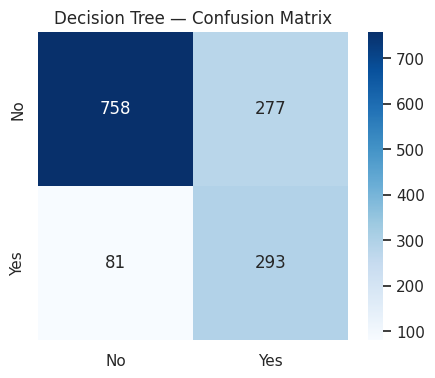


=== MLPClassifier ===
Accuracy : 0.7835
Precision: 0.6075
Recall   : 0.5214
F1 Score : 0.5612
ROC AUC  : 0.8295

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



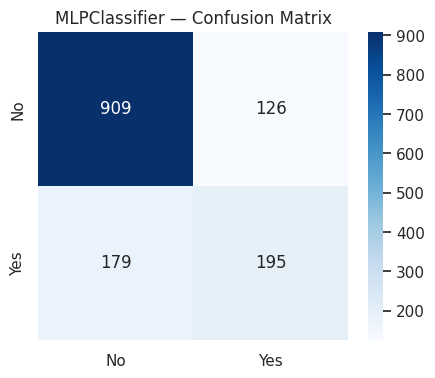

In [30]:
# ============================================
# Model Evaluation Function
# ============================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

def evaluate(model, X_test, y_test, label):
    """Evaluates a model and prints all performance metrics."""

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n=== {label} ===")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall   :", round(recall_score(y_test, y_pred), 4))
    print("F1 Score :", round(f1_score(y_test, y_pred), 4))
    print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No","Yes"], yticklabels=["No","Yes"])
    plt.title(f"{label} — Confusion Matrix")
    plt.show()

    return y_prob

dt_prob = evaluate(dt_best, X_test, y_test, "Decision Tree")
mlp_prob = evaluate(mlp_best, X_test, y_test, "MLPClassifier")



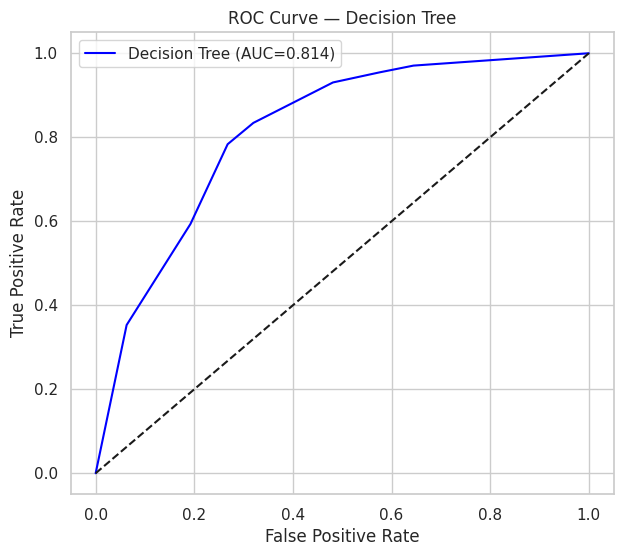

In [31]:
# ============================================
# ROC Curve — Decision Tree
# ============================================

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={roc_auc_score(y_test, dt_prob):.3f})", color="blue")
plt.plot([0,1],[0,1], "k--")
plt.title("ROC Curve — Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


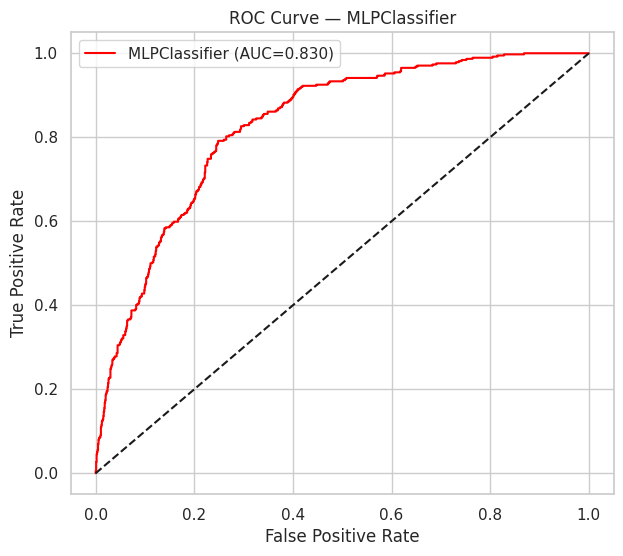

In [32]:
# ============================================
# ROC Curve — MLPClassifier
# ============================================

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLPClassifier (AUC={roc_auc_score(y_test, mlp_prob):.3f})", color="red")
plt.plot([0,1],[0,1], "k--")
plt.title("ROC Curve — MLPClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# ============================================
# Final Model Comparison Table
# ============================================

comparison_df = pd.DataFrame([
    {
        "Model": "Decision Tree",
        "Accuracy": accuracy_score(y_test, dt_best.predict(X_test)),
        "Precision": precision_score(y_test, dt_best.predict(X_test)),
        "Recall": recall_score(y_test, dt_best.predict(X_test)),
        "F1": f1_score(y_test, dt_best.predict(X_test)),
        "ROC_AUC": roc_auc_score(y_test, dt_prob)
    },
    {
        "Model": "MLPClassifier",
        "Accuracy": accuracy_score(y_test, mlp_best.predict(X_test)),
        "Precision": precision_score(y_test, mlp_best.predict(X_test)),
        "Recall": recall_score(y_test, mlp_best.predict(X_test)),
        "F1": f1_score(y_test, mlp_best.predict(X_test)),
        "ROC_AUC": roc_auc_score(y_test, mlp_prob)
    }
])

print("\n=== Final Model Comparison ===")
display(comparison_df)



=== Final Model Comparison ===


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Decision Tree,0.745919,0.514035,0.783422,0.620763,0.814413
1,MLPClassifier,0.783534,0.607477,0.521390,0.561151,0.829533
